In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [2]:
dev = qml.device("default.qubit",wires=8)

In [3]:
def Ue(x,i):
    #print("x inside rx",x)
    qml.RX(x,wires=i)
    
def U1(p1,p2,i,j):
    qml.CRX(p1,wires=[i,j])
    qml.CRX(p2,wires=[j,i])
    
def U2(p,c):
    for k in range(c):
        qml.CRX(p[k],wires=[k,(k+1)%c])

In [4]:
def layer(layer_weights):
    #qml.Hadamard(wires=0)
    #qml.Hadamard(wires=1)
    for wire in range(4):
        qml.RY(layer_weights[wire], wires=[wire])
    for i in range(4):
        qml.CNOT(wires=[i, (i+1)%4])
    #qml.Hadamard(wires=0)
    #qml.Hadamard(wires=1)
    #print(qml.state())

In [5]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2])

    #return x


def state_preparation(a):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)

    qml.CNOT(wires=[0, 1])
    #qml.RX(a[1], wires=1)
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    
    qml.CNOT(wires=[1,2])
    #qml.RX(a[2], wires=2)
    qml.RY(a[2], wires=2)
    qml.CNOT(wires=[1,2])
    
    
    #qml.PauliX(wires=0)
    
    qml.CNOT(wires=[2, 3])
    #qml.RX(a[3], wires=3)
    qml.RY(a[3], wires=3)
    qml.CNOT(wires=[2, 3])
    
    
    qml.CNOT(wires=[3,0])
    #qml.RX(a[0], wires=0)
    qml.RY(a[0], wires=0)
    qml.CNOT(wires=[3,0])
    #qml.RY(a[4], wires=1)
    #qml.PauliX(wires=0)
    
    
    
    

In [6]:
@qml.qnode(dev)
def circuit_final(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)
    #
    
    return qml.expval(qml.PauliZ(0))  #np.array([qml.expval(qml.PauliZ(i)) for i in range(4)]) #qml.expval(qml.PauliZ(0))  #qml.state()

In [7]:
@qml.qnode(dev)
def circuit(p, q,k,t):
    #state_preparation(x)

    #for t in range(4):
        # Ue encoding
    #print("----------",t)
    #print("q.shape,k.shape",q.shape,k.shape)
    for n in range(4):
        #print("q[t', k[n],",q[t].shape,k[n].shape,q[t],k[n])
        Ue( q[t], n*2 )
        Ue( k[n], n*2 )
        
    #print('encoding done')
         
        # U1 construction
    for y in range(2):
        U1( p[y*2],p[y*2+1], y*2 , y*2 +1 )
            
        
        # U2 construction    
    U2(p[8:16],8)
        
    #print('first layer done')
    #
    #print('all layers done')
    return qml.expval(qml.PauliZ(0)) #np.array([qml.expval(qml.PauliZ(i)) for i in range(0,32,8)]) #qml.expval(qml.PauliZ(0))  #qml.state()
    #return np.array([qml.expval(qml.PauliZ(i)) for i in range(0,8,2)]) 

In [8]:
@qml.qnode(dev)
def circuit_compressed(p, q,k,t):
    #state_preparation(x)

    #for t in range(4):
        # Ue encoding
    #print("----------",t)
    #print("q.shape,k.shape",q.shape,k.shape)
    for n in range(4):
        #print("q[t', k[n],",q[t].shape,k[n].shape,q[t],k[n])
        Ue( q[t], n )
        Ue( k[n], n )
        
    #print('encoding done')
         
        # U1 construction
    for y in range(4-1):
        U1( p[y*2],p[y*2+1], y , y +1 )
            
        
        # U2 construction    
    U2(p[8:16],4)
        
    #print('first layer done')
    #
    #print('all layers done')
    return qml.expval(qml.PauliZ(0)) #np.array([qml.expval(qml.PauliZ(i)) for i in range(0,32,8)]) #qml.expval(qml.PauliZ(0))  #qml.state()
    #return np.array([qml.expval(qml.PauliZ(i)) for i in range(0,8,2)]) 

In [9]:
def variational_classifier(params, bias, x):
    #qml.drawer.use_style('black_white')
    #fig, ax = qml.draw_mpl(circuit)(weights,x)
    #print(weights.shape,bias.shape, x.shape)
    res=[]
    #print("_____________________________________inside variational after cost_______________shape of x")
    #print(x.shape)
    for i in range(4):
        res.append(circuit_compressed(params[i], x,x,i) + bias)
        #print(i,res)
    return circuit_final(params[4:],res)
    #return np.array(res)[0]
    

In [10]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [11]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [12]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    #print('before cost')
    predictions = [variational_classifier(weights, bias, i.T) for i in X]
    #if predictions.shape[-1]<10:
        #print("v",predictions)
    #print('after cost____square loss error')
    
    return square_loss(Y, predictions)

In [32]:
# Import necessary libraries
import yfinance as yf
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Download Apple Inc. stock data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')

# Use the 'Close' price for prediction
close_prices = aapl_data['Close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

# Prepare the dataset
X = close_prices_scaled[:-1]
y = close_prices_scaled[1:]

# Reshape for LSTM
X = X.reshape(-1, 1, 1)
y = y.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




[*********************100%%**********************]  1 of 1 completed


In [33]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_train.shape,X_test.shape


((604, 1, 1), (151, 1, 1))

In [34]:
c=0
for i in y:
    if i<0:
        c+=1
c

211

In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_train.shape,X_test.shape


((604, 1, 1), (151, 1, 1))

In [36]:
X_train_tensor[:3]

tensor([[[-0.6983]],

        [[-0.7099]],

        [[-0.7005]]])

In [37]:
print(np.array(X_train_tensor.reshape(X_train_tensor.shape[0],X_train_tensor.shape[-1])).shape)

(604, 1)


In [38]:
X_test_tensor.shape

torch.Size([151, 1, 1])

In [39]:
num_qubits = 4
num_layers = 1
from pennylane import numpy as np

weights_init = 0.01 * np.random.randn(4 + num_layers, 16, requires_grad=True) #+ 0.01 * np.random.randn(num_layers, num_qubits, requires_grad=True)
#weight_final = 0.01 * np.random.randn(num_layers, num_qubits,3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [40]:
#normalization = np.sqrt(np.sum(X**2, -1))
from sklearn.preprocessing import MinMaxScaler

In [41]:
def QSANN(input,y,weights,bias,train):
        #print("inside_qsann",input.shape)
        opt = NesterovMomentumOptimizer(0.1)
        num_train = input.shape[0]
        batch_size=100
        X = input.detach().numpy()
        #scaler = MinMaxScaler()
        #X_norm = scaler.fit_transform(X)
        features = 2*np.pi*X
        #print("angles ready")
        if train == True:
            for i in range(0, num_train, batch_size):
                # Create mini-batch            
                feats_batch = features[i:i + batch_size]
                #print("feats_type",type(feats_batch))
                Y_batch = np.array(y[i:i + batch_size])
                #print("Y_batch type",type(feats_batch))
                # Print shapes for debugging
                #print("weights shape:", weights.shape)
                #print("bias shape:", bias.shape)
                if feats_batch.shape[0]!=100:
                      break
                #print("feats_train_batch shape:", feats_batch.shape,type(feats_batch))
                #print("Y_train_batch shape:", Y_batch.shape,type(feats_batch))

                # Update the weights by one optimizer step
                weights, bias, _, _ = opt.step(cost, weights, bias, feats_batch, Y_batch)
                #if i %100==0:

        #score = np.array([np.sign(variational_classifier(weights, bias, i.T)) for i in features])
        score = np.array([variational_classifier(weights, bias, i.T) for i in features])        
        #print("-----Quantum measurement SCore: ",score.shape,score[:5])
        return score,weights,bias

In [44]:
def scale_range(arr, new_min, new_max):
    #arr = arr.detach().numpy()
    old_min, old_max = torch.min(arr), torch.max(arr)
    scaled = ((arr - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
    #print(scaled.shape,type(scaled))
    return scaled


In [46]:
# Define an LSTM with Attention mechanism
from sklearn.preprocessing import MinMaxScaler

class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1,num_qubits=4,num_layers_vqc=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.num_qubits = num_qubits#4
        self.num_layers_vqc = num_layers_vqc#4
        #self.weights_init = weights_init#0.01 * np.random.randn(4 + num_layers_vqc, 16, requires_grad=True) #+ 0.01 * np.random.randn(num_layers, num_qubits, requires_grad=True)
        #weight_final = 0.01 * np.random.randn(num_layers, num_qubits,3, requires_grad=True)
        #self.bias_init = bias_init#np.array(0.0, requires_grad=True)
        

    def forward(self, x,y,train_flag,weights_init,bias_init):
        #print("X shape",x.shape,x[0])
        lstm_out, _ = self.lstm(x)
        #print("LSTM out:",lstm_out.shape,lstm_out[:3])
        #attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        
        #print(lstm_out.reshape(lstm_out.shape[0],lstm_out.shape[-1]).shape)
        lstm_out_reshaped = lstm_out.reshape(lstm_out.shape[0],lstm_out.shape[-1])
        #print(lstm_out_reshaped.shape,lstm_out_reshaped[0][0])
        quantum_attention,W_,b_ = QSANN(lstm_out_reshaped,y,weights=weights_init,bias=bias_init,train = train_flag)
        self.weights_init = W_
        self.bias_init = b_
        #print("-------------quantum attention weights",quantum_attention.shape,type(quantum_attention),quantum_attention[:3])
        quantum_attention = torch.tensor(quantum_attention, dtype=torch.float32)
        context_vector = torch.sum(lstm_out * quantum_attention.unsqueeze(-1), dim=1)
        #print("context vector ",context_vector.shape,type(context_vector),context_vector[0:3])
        #context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        #print("out",out.shape,out[:3])
        #print(quantum_attention.shape,quantum_attention[0])
        #out = quantum_attention
        if train_flag==False:
            out_scaled = scale_range(out,torch.min(torch.tensor(y)),torch.max(torch.tensor(y)))
            print("*test",out_scaled[:3])
        else:
            out_scaled = out
            print("train",out_scaled[:3])
        
        return out_scaled,self.weights_init,self.bias_init

In [47]:
# Instantiate the model
model = LSTMAttention(input_dim=1, hidden_dim=4)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
epochs = 70
train_loss_list,test_loss_list = [],[]
test_pred_list=[]
for epoch in range(epochs):
    print("-----------------------Epoch:",epoch)
    model.train()
    optimizer.zero_grad()
    print(X_train_tensor.shape,y_train.shape,type(X_train_tensor),type(y_train))
    output_tensor,weights_init,bias_init = model(X_train_tensor,y_train,train_flag = True,weights_init=weights_init,bias_init=bias_init)
    #output_tensor = torch.tensor(output, dtype=torch.float32)
    loss = criterion(output_tensor, y_train_tensor)
    #print("Loss type and Loss",type(loss),loss)
    loss.backward()
    optimizer.step()

    if epoch % 1 == 0:
        model.eval()
        test_pred,_,_ = model(X_test_tensor,y_test_tensor,train_flag=False,weights_init=weights_init,bias_init=bias_init)
        test_pred_list.append(test_pred)
        test_loss = criterion(test_pred, y_test_tensor)
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')


-----------------------Epoch: 0
torch.Size([604, 1, 1]) (604, 1) <class 'torch.Tensor'> <class 'numpy.ndarray'>
train tensor([[0.3313],
        [0.3435],
        [0.3336]], grad_fn=<SliceBackward0>)


C:\Users\Lokes S\AppData\Local\Temp\ipykernel_32424\781387909.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out_scaled = scale_range(out,torch.min(torch.tensor(y)),torch.max(torch.tensor(y)))


*test tensor([[0.6176],
        [0.5619],
        [0.4656]], grad_fn=<SliceBackward0>)
Epoch 0, Loss: 1.1882203817367554, Test Loss: 0.11087272316217422
-----------------------Epoch: 1
torch.Size([604, 1, 1]) (604, 1) <class 'torch.Tensor'> <class 'numpy.ndarray'>
train tensor([[0.5083],
        [0.5226],
        [0.5110]], grad_fn=<SliceBackward0>)
*test tensor([[0.6187],
        [0.5632],
        [0.4669]], grad_fn=<SliceBackward0>)
Epoch 1, Loss: 1.3005955219268799, Test Loss: 0.11094007641077042
-----------------------Epoch: 2
torch.Size([604, 1, 1]) (604, 1) <class 'torch.Tensor'> <class 'numpy.ndarray'>
train tensor([[0.2933],
        [0.3017],
        [0.2949]], grad_fn=<SliceBackward0>)
*test tensor([[0.3729],
        [0.4283],
        [0.5245]], grad_fn=<SliceBackward0>)
Epoch 2, Loss: 0.7761505246162415, Test Loss: 0.003953603096306324
-----------------------Epoch: 3
torch.Size([604, 1, 1]) (604, 1) <class 'torch.Tensor'> <class 'numpy.ndarray'>
train tensor([[-0.4353],
     

In [ ]:
l=[]
train_qsan,test_qsan = [],[]
for i in s.split('\n'):
    if i[0]!='-':
        l.append(i)
for it in l:
    i = it.split(',')
    train_qsan.append(float(i[0]))
    test_qsan.append(float(i[1].split(' ')[-1]))
train_qsan[:5],test_qsan[:5]

([0.5638901591300964,
  0.29121774435043335,
  0.09167864173650742,
  0.056831009685993195,
  0.1155426949262619],
 [0.43215033411979675,
  0.36395660042762756,
  0.31926029920578003,
  0.2909533679485321,
  0.27168089151382446])

['0.5638901591300964', ' Test Loss: 0.43215033411979675']

In [25]:
print("""Epoch 0, Loss: 0.5631675720214844, Test Loss: 0.719024121761322
Epoch 1, Loss: 0.27591249346733093, Test Loss: 0.6887628436088562n
Epoch 2, Loss: 0.10333028435707092, Test Loss: 0.6612901091575623n
Epoch 3, Loss: 0.03366914018988609, Test Loss: 0.6380996704101562n
Epoch 4, Loss: 0.03766975924372673, Test Loss: 0.6203319430351257n
Epoch 5, Loss: 0.07943626493215561, Test Loss: 0.6091803908348083n
Epoch 6, Loss: 0.12452925741672516, Test Loss: 0.604627788066864
Epoch 7, Loss: 0.1481732428073883, Test Loss: 0.605309009552002
Epoch 8, Loss: 0.144590362906456, Test Loss: 0.6097305417060852
Epoch 9, Loss: 0.1211218386888504, Test Loss: 0.6167397499084473
Epoch 10, Loss: 0.08894680440425873, Test Loss: 0.6254490613937378
Epoch 11, Loss: 0.058195989578962326, Test Loss: 0.635088622570037
Epoch 12, Loss: 0.03594287484884262, Test Loss: 0.6449064612388611
Epoch 13, Loss: 0.025467388331890106, Test Loss: 0.654146790504455
Epoch 14, Loss: 0.02632252313196659, Test Loss: 0.6621034145355225
Epoch 15, Loss: 0.03514423221349716, Test Loss: 0.6682085990905762
Epoch 16, Loss: 0.0470057874917984, Test Loss: 0.6721011400222778
Epoch 17, Loss: 0.05697145685553551, Test Loss: 0.6736536622047424
Epoch 20, Loss: 0.052375372499227524, Test Loss: 0.666161119937896
Epoch 25, Loss: 0.025174610316753387, Test Loss: 0.640034079551696
Epoch 30, Loss: 0.035547077655792236, Test Loss: 0.636203765869140
Epoch 35, Loss: 0.02413066290318966, Test Loss: 0.6515439748764038
Epoch 40, Loss: 0.02832668088376522, Test Loss: 0.6555470824241638
Epoch 45, Loss: 0.024076662957668304, Test Loss: 0.645753860473632
Epoch 49, Loss: 0.025656575337052345, Test Loss: 0.642664313316345""")

Epoch 0, Loss: 0.5631675720214844, Test Loss: 0.719024121761322
Epoch 1, Loss: 0.27591249346733093, Test Loss: 0.6887628436088562n
Epoch 2, Loss: 0.10333028435707092, Test Loss: 0.6612901091575623n
Epoch 3, Loss: 0.03366914018988609, Test Loss: 0.6380996704101562n
Epoch 4, Loss: 0.03766975924372673, Test Loss: 0.6203319430351257n
Epoch 5, Loss: 0.07943626493215561, Test Loss: 0.6091803908348083n
Epoch 6, Loss: 0.12452925741672516, Test Loss: 0.604627788066864
Epoch 7, Loss: 0.1481732428073883, Test Loss: 0.605309009552002
Epoch 8, Loss: 0.144590362906456, Test Loss: 0.6097305417060852
Epoch 9, Loss: 0.1211218386888504, Test Loss: 0.6167397499084473
Epoch 10, Loss: 0.08894680440425873, Test Loss: 0.6254490613937378
Epoch 11, Loss: 0.058195989578962326, Test Loss: 0.635088622570037
Epoch 12, Loss: 0.03594287484884262, Test Loss: 0.6449064612388611
Epoch 13, Loss: 0.025467388331890106, Test Loss: 0.654146790504455
Epoch 14, Loss: 0.02632252313196659, Test Loss: 0.6621034145355225
Epoch 15

In [44]:
import numpy as np

def scale_range(arr, new_min, new_max):
    old_min, old_max = np.min(arr), np.max(arr)
    return ((arr - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

# Example array
arr = np.array([1.2, 2.5, 3.8, 5.1])

# Scale to range [0, 1]
scaled_arr = scale_range(arr, 0, 1)
print(scaled_arr)

# Scale to range [-1, 1]
scaled_arr = scale_range(arr, -1, 1)
print(scaled_arr)

[0.         0.33333333 0.66666667 1.        ]
[-1.         -0.33333333  0.33333333  1.        ]


In [38]:
# Predictions
model.eval()
predictions =model(X_test_tensor,y_test_tensor,train_flag=False,weights_init=weights_init,bias_init=bias_init)[0].detach().numpy()



# Metrics

In [51]:

scaled_prediction = scale_range(predictions,min(y_test),max(y_test))

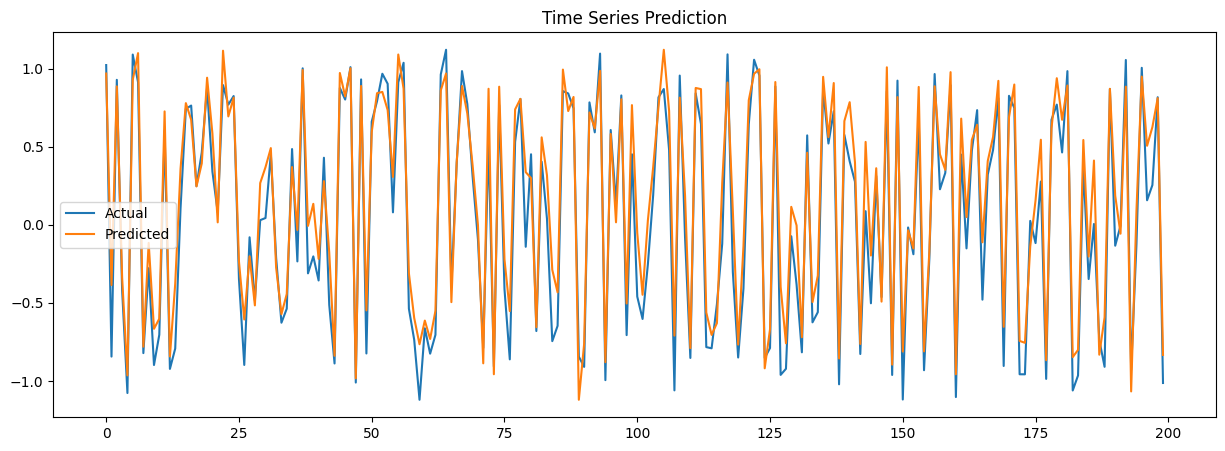

In [52]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(scaled_prediction, label='Predicted')
plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [53]:
scaled_prediction[:5],y_test[:5]

(array([[ 0.96783889],
        [-0.38590938],
        [ 0.88591771],
        [-0.33605863],
        [-0.9643475 ]]),
 array([[ 1.02219448],
        [-0.84385962],
        [ 0.92767353],
        [-0.4174078 ],
        [-1.07710113]]))

In [54]:

mse = mean_squared_error(y_test , scaled_prediction)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.03779949563657164


[0.         0.33333333 0.66666667 1.        ]
[-1.         -0.33333333  0.33333333  1.        ]


# Classical LSTM approach

Epoch 0, Loss: 0.7252493500709534, Test Loss: 0.7452210187911987
Epoch 1, Loss: 0.7066338062286377, Test Loss: 0.724955677986145
Epoch 2, Loss: 0.6884163618087769, Test Loss: 0.705100417137146
Epoch 3, Loss: 0.6705934405326843, Test Loss: 0.6856476068496704
Epoch 4, Loss: 0.6531580686569214, Test Loss: 0.6665867567062378
Epoch 5, Loss: 0.6361004710197449, Test Loss: 0.647905707359314
Epoch 6, Loss: 0.6194090247154236, Test Loss: 0.6295908689498901
Epoch 7, Loss: 0.6030712127685547, Test Loss: 0.6116287112236023
Epoch 8, Loss: 0.5870744585990906, Test Loss: 0.5940070152282715
Epoch 9, Loss: 0.5714072585105896, Test Loss: 0.5767152309417725
Epoch 10, Loss: 0.5560594797134399, Test Loss: 0.5597456693649292
Epoch 11, Loss: 0.5410234928131104, Test Loss: 0.5430936217308044
Epoch 12, Loss: 0.5262938737869263, Test Loss: 0.5267574191093445
Epoch 13, Loss: 0.5118680000305176, Test Loss: 0.5107389092445374
Epoch 14, Loss: 0.4977457821369171, Test Loss: 0.49504268169403076
Epoch 15, Loss: 0.4839

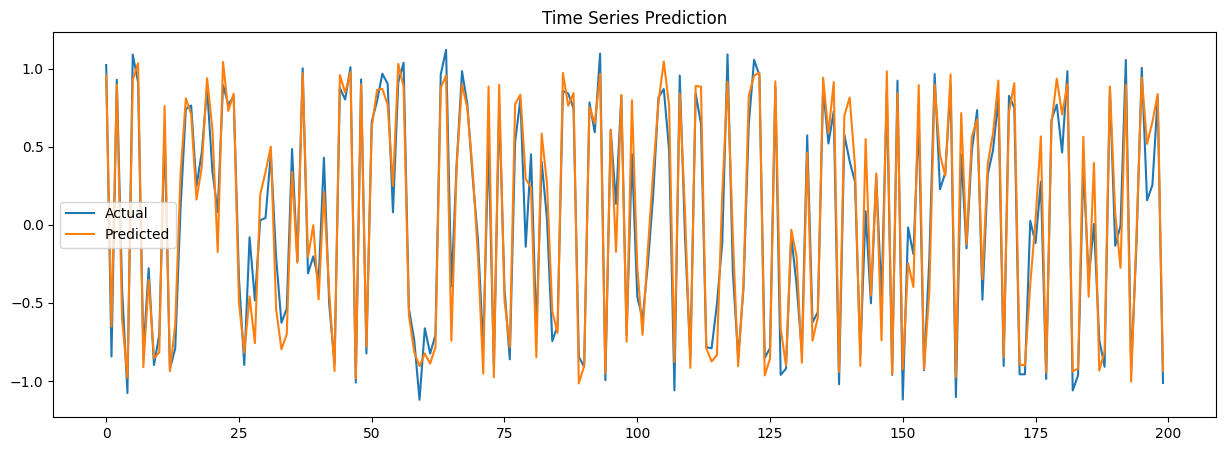

Mean Squared Error: 0.026871100959251725


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate a synthetic time series dataset
np.random.seed(0)
time = np.arange(0, 100, 0.1)
amplitude = np.sin(time) + np.random.normal(0, 0.1, len(time))
X = amplitude[:-1]
y = amplitude[1:]

# Reshape data for the model
X = X.reshape(-1, 1, 1)
y = y.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define an LSTM with Attention mechanism
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        return out

# Instantiate the model
model = LSTMAttention(input_dim=1, hidden_dim=4)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loss_list_classical,test_loss_list_classical = [],[]
# Training the model
epochs = 70
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 1 == 0:
        model.eval()
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')
        train_loss_list_classical.append(loss.item())
        test_loss_list_classical.append(test_loss.item())

# Predictions
model.eval()
predictions = model(X_test_tensor).detach().numpy()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Time Series Prediction')
plt.legend()
plt.show()

# Metrics
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Interpretation
# The plot shows how well the LSTM model with attention mechanism can predict the future values of a time series.
# The MSE provides a quantitative measure of the model's prediction accuracy.

NameError: name 'train_loss_list' is not defined

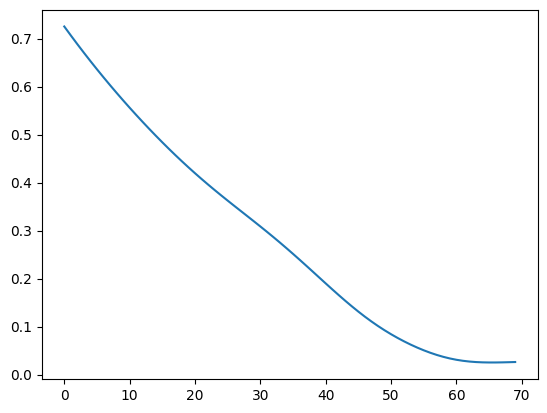

In [2]:
# Plotting_train

#plt.figure(figsize=(15, 5))
plt.plot(train_loss_list_classical, label='LSTM')
plt.plot(train_loss_list, label='Hybrid LSTM QSAN')
plt.title('Training Loss')
plt.legend()
plt.show()

# Classical Batch Processing

Epoch 0, Loss: 0.3493123948574066, Test Loss: 0.3568446636199951
Epoch 1, Loss: 0.3230282962322235, Test Loss: 0.32950904965400696
Epoch 2, Loss: 0.29939207434654236, Test Loss: 0.30504441261291504
Epoch 3, Loss: 0.2765001356601715, Test Loss: 0.28193703293800354
Epoch 4, Loss: 0.2539367377758026, Test Loss: 0.2596770226955414
Epoch 5, Loss: 0.2317853718996048, Test Loss: 0.23768655955791473
Epoch 6, Loss: 0.20968231558799744, Test Loss: 0.2151186168193817
Epoch 7, Loss: 0.18759796023368835, Test Loss: 0.19200380146503448
Epoch 8, Loss: 0.16619908809661865, Test Loss: 0.16943415999412537
Epoch 9, Loss: 0.14642006158828735, Test Loss: 0.14867836236953735
Epoch 10, Loss: 0.12911510467529297, Test Loss: 0.13063956797122955
Epoch 11, Loss: 0.1147424578666687, Test Loss: 0.11567680537700653
Epoch 12, Loss: 0.1032290831208229, Test Loss: 0.1036735475063324
Epoch 13, Loss: 0.09416601806879044, Test Loss: 0.09423323720693588
Epoch 14, Loss: 0.08705323189496994, Test Loss: 0.08684945106506348
E

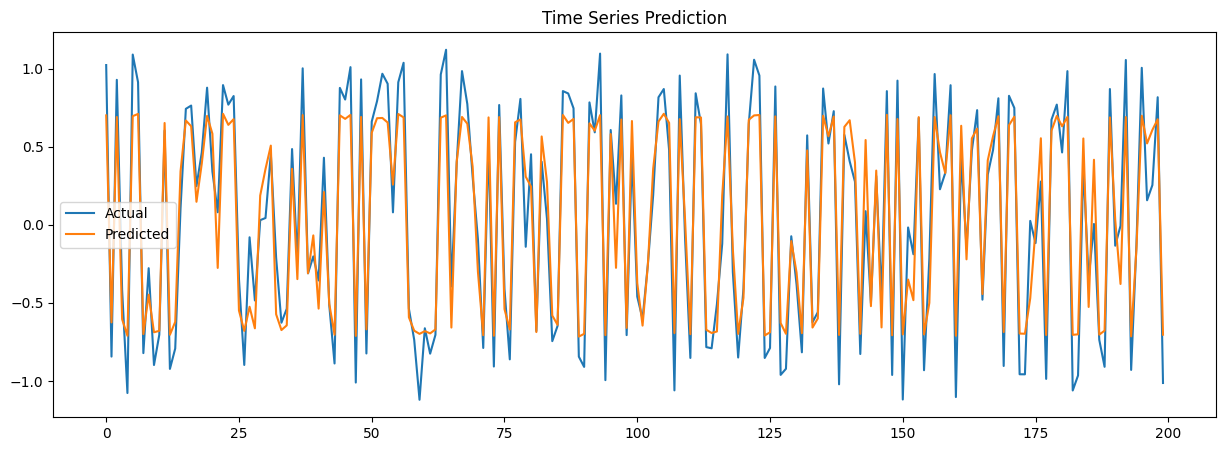

Mean Squared Error: 0.04633211340061548


In [83]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate a synthetic time series dataset
np.random.seed(0)
time = np.arange(0, 100, 0.1)
amplitude = np.sin(time) + np.random.normal(0, 0.1, len(time))
X = amplitude[:-1]
y = amplitude[1:]

# Reshape data for the model
X = X.reshape(-1, 1, 1)
y = y.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define an LSTM with Attention mechanism
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, output_dim, num_layers, batch_first=True)
        #self.attention = nn.Linear(hidden_dim, 1)
        #self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        #attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        #ontext_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        lstm_out_reshaped = lstm_out.reshape(lstm_out.shape[0],lstm_out.shape[-1])
        #out = self.fc(lstm_out_reshaped)
        return lstm_out_reshaped

# Instantiate the model
model = LSTMAttention(input_dim=1, hidden_dim=4)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loss_list_classical,test_loss_list_classical = [],[]
# Training the model
epochs = 70


#epochs = 100
for epoch in range(epochs):
    num_train = X_train.shape[0]
    batch_size=100
    for i in range(0, num_train, batch_size):
        # Create mini-batch            
        feats_batch = X_train_tensor[i:i + batch_size]
        #print("feats_type",type(feats_batch))
        Y_batch = y_train_tensor[i:i + batch_size]
        #print("Y_batch type",type(feats_batch))
        # Print shapes for debugging
        #print("weights shape:", weights.shape)
        #print("bias shape:", bias.shape)
        if feats_batch.shape[0]!=100:
              break
        
        model.train()
        optimizer.zero_grad()
        output = model(feats_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        #print("feats_train_batch shape:", feats_batch.shape,type(feats_batch))
        #print("Y_train_batch shape:", Y_batch.shape,type(feats_batch)
        # Update the weights by one optimizer step
        #weights, bias, _, _ = opt.step(cost, weights, bias, feats_batch, Y_batch)
        #if i %100==0:


#        
#for epoch in range(epochs):
#    model.train()
#    optimizer.zero_grad()
#    output = model(X_train_tensor)
#    loss = criterion(output, y_train_tensor)
#    loss.backward()
#    optimizer.step()
#
    if epoch % 1 == 0:
        model.eval()
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        #print("test_pred, y_test_tensor",test_pred,y_test_tensor)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')
        train_loss_list_classical.append(loss.item())
        test_loss_list_classical.append(test_loss.item())

# Predictions
model.eval()
predictions = model(X_test_tensor).detach().numpy()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Time Series Prediction')
plt.legend()
plt.show()

# Metrics
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Interpretation
# The plot shows how well the LSTM model with attention mechanism can predict the future values of a time series.
# The MSE provides a quantitative measure of the model's prediction accuracy.

In [84]:
train_loss_list,test_loss_list

([0.28104501962661743,
  0.21777820587158203,
  0.12114447355270386,
  0.09107135981321335,
  0.10235219448804855,
  0.11142025142908096,
  0.10362164676189423,
  0.08732371032238007,
  0.07375022768974304,
  0.06879359483718872,
  0.07209572196006775,
  0.0790771022439003,
  0.08420348167419434,
  0.0838758647441864,
  0.07759244740009308,
  0.0673973336815834,
  0.05651989206671715,
  0.04798036813735962,
  0.043542347848415375,
  0.043209902942180634,
  0.04542604088783264,
  0.04795081540942192,
  0.0490068681538105,
  0.04803607612848282,
  0.04568077623844147,
  0.04315011575818062,
  0.041446883231401443,
  0.040878478437662125,
  0.04103410989046097,
  0.04114628955721855,
  0.040576107800006866,
  0.03914542496204376,
  0.03717340901494026,
  0.03525559976696968,
  0.03393745422363281,
  0.03345416486263275,
  0.03365162014961243,
  0.034107331186532974,
  0.03436961770057678,
  0.03417797386646271,
  0.03355220705270767,
  0.032724298536777496,
  0.0319758765399456,
  0.03148

In [85]:
len(train_qsan)

NameError: name 'train_qsan' is not defined

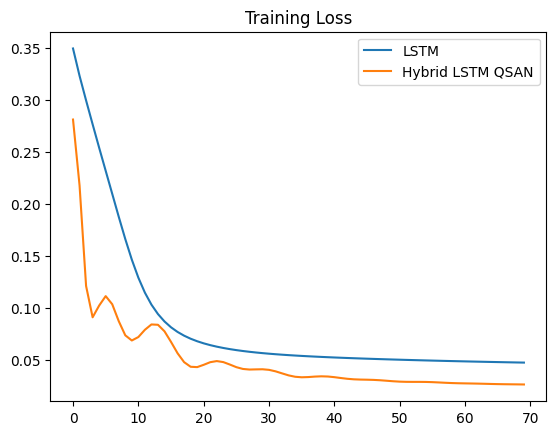

In [86]:
# Plotting_train

#plt.figure(figsize=(15, 5))
plt.plot(train_loss_list_classical, label='LSTM')
plt.plot(train_loss_list, label='Hybrid LSTM QSAN')
plt.title('Training Loss')
plt.legend()
plt.show()

In [30]:
test_qsan

array([0.03413988, 0.02875257, 0.02522156, 0.02298532, 0.02146279,
       0.02045687, 0.01993085, 0.01988211, 0.02028028, 0.02102505,
       0.02193507, 0.02279032, 0.02341559, 0.02373872, 0.02378502,
       0.02363638, 0.02339082, 0.02313485, 0.02292859, 0.02280218,
       0.02276162, 0.02279975, 0.02290572, 0.02306877, 0.02327612,
       0.02350839, 0.02373656, 0.02392322, 0.0240291 , 0.02402318,
       0.02389219, 0.02364572, 0.02331449, 0.02294332, 0.02258131,
       0.02227284, 0.0220512 , 0.02193583, 0.0219326 , 0.02203555,
       0.02222877, 0.02248795, 0.02278193, 0.0230754 , 0.0233331 ,
       0.02352512, 0.02363192, 0.02364745, 0.02357934, 0.02344628,
       0.02327361, 0.0230885 , 0.02291579, 0.02277515, 0.0226795 ,
       0.02263434, 0.02263792, 0.02268199, 0.02275328, 0.02283585,
       0.02291407, 0.02297547, 0.02301282, 0.02302499, 0.02301614,
       0.02299403, 0.02296775, 0.0229456 , 0.02293358, 0.02293452])

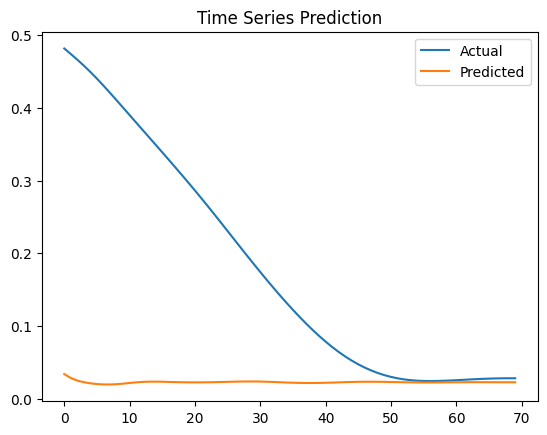

In [29]:
# Plotting
#plt.figure(figsize=(15, 5))
test_qsan = np.array(test_qsan)*0.079
plt.plot(test_loss_list, label='Actual')
plt.plot(test_qsan, label='Predicted')
plt.title('Time Series Prediction')
plt.legend()
plt.show()

test_pred, y_test_tensor tensor([[0.0566, 0.0014],
        [0.0368, 0.0046],
        [0.0544, 0.0017],
        [0.0371, 0.0045],
        [0.0348, 0.0057],
        [0.0555, 0.0016],
        [0.0604, 0.0009],
        [0.0352, 0.0053],
        [0.0387, 0.0041],
        [0.0355, 0.0051],
        [0.0358, 0.0050],
        [0.0507, 0.0022],
        [0.0350, 0.0055],
        [0.0368, 0.0046],
        [0.0441, 0.0032],
        [0.0518, 0.0021],
        [0.0495, 0.0024],
        [0.0425, 0.0034],
        [0.0446, 0.0031],
        [0.0559, 0.0015],
        [0.0478, 0.0026],
        [0.0399, 0.0039],
        [0.0609, 0.0008],
        [0.0500, 0.0023],
        [0.0526, 0.0019],
        [0.0377, 0.0043],
        [0.0357, 0.0050],
        [0.0380, 0.0043],
        [0.0361, 0.0048],
        [0.0428, 0.0034],
        [0.0442, 0.0032],
        [0.0462, 0.0029],
        [0.0375, 0.0044],
        [0.0359, 0.0049],
        [0.0365, 0.0047],
        [0.0442, 0.0032],
        [0.0394, 0.0040],
        [0.05

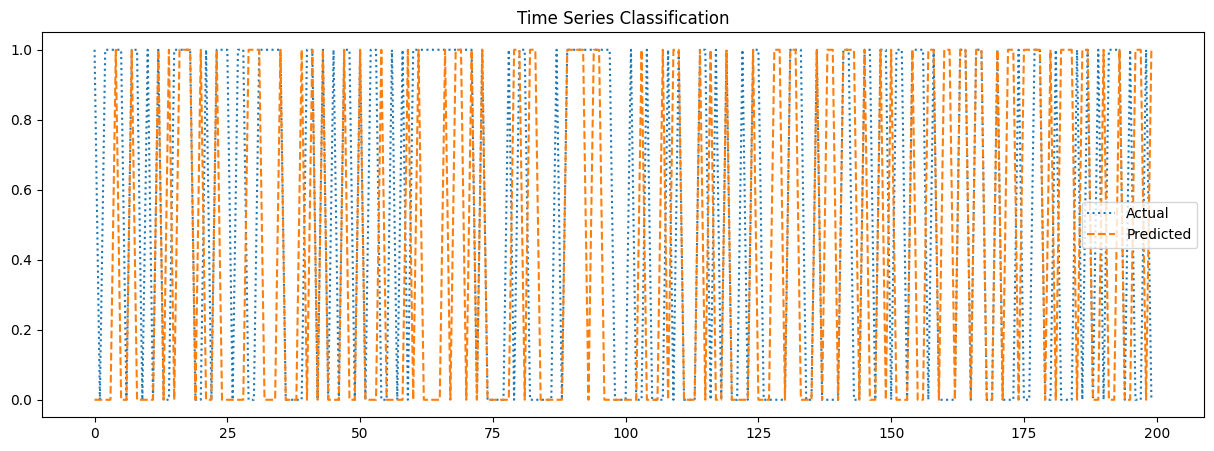

Accuracy: 0.5350


In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a synthetic time series dataset
np.random.seed(0)
time = np.arange(0, 100, 0.1)
amplitude = np.sin(time) + np.random.normal(0, 0.1, len(time))
X = amplitude[:-1]
y = amplitude[1:]

# Create binary labels: 1 if the current value is higher than the previous one, else 0
y = (y > X.flatten()).astype(int)

# Reshape data for the model
X = X.reshape(-1, 1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # For classification, use long type
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define an LSTM with Attention mechanism for classification
class LSTMAttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2, num_layers=1):
        super(LSTMAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        return out
    
    

# Instantiate the model
model = LSTMAttentionClassifier(input_dim=1, hidden_dim=4)

# Loss and optimizer for classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
epochs = 100
for epoch in range(epochs):
    num_train = X_train.shape[0]
    batch_size=100
    for i in range(0, num_train, batch_size):
        # Create mini-batch            
        feats_batch = X_train_tensor[i:i + batch_size]
        #print("feats_type",type(feats_batch))
        Y_batch = y_train_tensor[i:i + batch_size]
        #print("Y_batch type",type(feats_batch))
        # Print shapes for debugging
        #print("weights shape:", weights.shape)
        #print("bias shape:", bias.shape)
        if feats_batch.shape[0]!=100:
              break
        
        model.train()
        optimizer.zero_grad()
        output = model(feats_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        #print("feats_train_batch shape:", feats_batch.shape,type(feats_batch))
        #print("Y_train_batch shape:", Y_batch.shape,type(feats_batch)
        # Update the weights by one optimizer step
        #weights, bias, _, _ = opt.step(cost, weights, bias, feats_batch, Y_batch)
        #if i %100==0:





    if epoch % 10 == 0:
        
        model.eval()
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        print("test_pred, y_test_tensor",test_pred,y_test_tensor)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')

        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_tensor)
            test_loss = criterion(test_pred, y_test_tensor)
            _, predicted = torch.max(test_pred, 1)
            accuracy = accuracy_score(y_test_tensor, predicted)
            print("test_pred, y_test_tensor",test_pred,y_test_tensor)
            print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}, Accuracy: {accuracy:.4f}')

# Predictions
model.eval()
with torch.no_grad():
    test_pred = model(X_test_tensor)
    _, predicted = torch.max(test_pred, 1)

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual', linestyle='dotted')
plt.plot(predicted.numpy(), label='Predicted', linestyle='dashed')
plt.title('Time Series Classification')
plt.legend()
plt.show()

# Metrics
accuracy = accuracy_score(y_test, predicted)
print(f'Accuracy: {accuracy:.4f}')
